# Utilities

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import sklearn 
from skimage import transform
from skimage.transform import rotate, AffineTransform,warp
from skimage.util import random_noise
from skimage import util
from skimage.filters import gaussian
from sklearn import preprocessing



import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [88]:
def showImage(image):
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

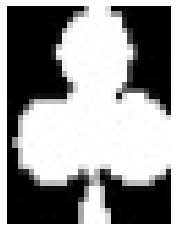

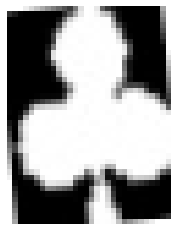

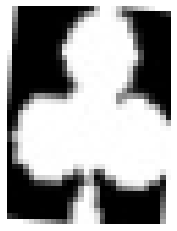

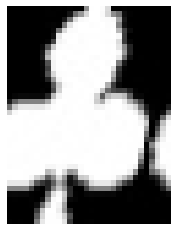

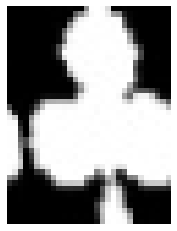

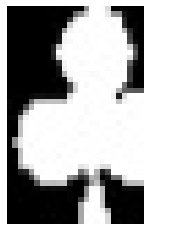

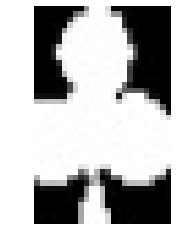

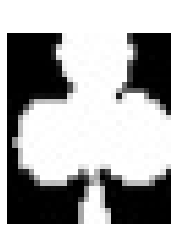

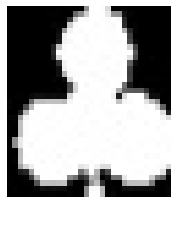

In [89]:

image = cv2.imread("DataSet/trainData/club/2C0.jpg", cv2.COLOR_BGR2GRAY)
showImage(image)

img = image

image = rotate(img, angle=5); 
showImage(image)
image = rotate(img, angle=-5); 
showImage(image)
image = transform.warp(img, AffineTransform(shear=-0.2), order=1, preserve_range=True, mode='wrap');
showImage(image)
image = transform.warp(img, AffineTransform(shear=0.1), order=1, preserve_range=True, mode='wrap'); 
showImage(image)
#----------------------------------------------------------------
image = img.copy();
image[:, 25:] = 0
showImage(image)

image = img.copy();
image[:, 0:5] = 0
showImage(image)

image = img.copy();
image[0:5,:] = 0
showImage(image)

image = img.copy();
image[35:, :] = 0
showImage(image)


In [90]:
# Image Augmentation, referncee: https://www.codespeedy.com/image-augmentation-using-skimage-in-python/

def augmentImage(img):
    augmentedImages=[img.flatten()]
    augmentedImages.append(img.flatten()) # add the image multiple times
    augmentedImages.append(img.flatten()) # add the image multiple times
    # rotation
    image = rotate(img, angle=5); augmentedImages.append(image.flatten())
    image = rotate(img, angle=-5); augmentedImages.append(image.flatten())
    # # Shearing
    image = transform.warp(img, AffineTransform(shear=-0.2), order=1, preserve_range=True, mode='wrap'); augmentedImages.append(image.flatten())
    image = transform.warp(img, AffineTransform(shear=0.1), order=1, preserve_range=True, mode='wrap'); augmentedImages.append(image.flatten())
    # # Cropping
    image = img.copy(); image[:, 23:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[:, 0:7] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[0:7,:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[33:, :] = 0; augmentedImages.append(image.flatten())
    
    return augmentedImages
    
    


# Import and split the data

In [91]:
import os
trainData = []
trainLabels = []

dire="DataSet/trainData" 

print(os.listdir(dire))

numClassesWithLimit = 0
LIMIT = 1150 # to have the same number of items in all classes
for innerDir in os.listdir(dire):
    count = 0
    for filename in os.listdir(dire+'/' +innerDir):
        # read image
        image = cv2.imread(dire+'/' + innerDir +'/' +filename, cv2.COLOR_BGR2GRAY)/255.0

        # augmentImage
        augmentedImages = augmentImage(image.copy())
        count +=  len(augmentedImages)

        # append images
        trainData+=augmentedImages
        trainLabels+=[innerDir] * len(augmentedImages)

        # to break the inner loop if the number of items in the class exceeded the LIMIT
        if (count >= LIMIT):
            numClassesWithLimit+=1
            print("Class", innerDir , "has", count, "items")
            break

print("Number of classes that have exceeded", LIMIT, "items is:", numClassesWithLimit, "out of", len(os.listdir(dire)))
print("trainData Size:", len(trainData), "and trainLabels size:", len(trainLabels))



['10', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'club', 'diamond', 'heart', 'J', 'K', 'Q', 'spade']
Class 10 has 1155 items
Class 2 has 1155 items
Class 3 has 1155 items
Class 4 has 1155 items
Class 6 has 1155 items
Class 7 has 1155 items
Class 8 has 1155 items
Class 9 has 1155 items
Class A has 1155 items
Class club has 1155 items
Class diamond has 1155 items
Class heart has 1155 items
Class J has 1155 items
Class K has 1155 items
Class Q has 1155 items
Class spade has 1155 items
Number of classes that have exceeded 1150 items is: 16 out of 17
trainData Size: 19525 and trainLabels size: 19525


In [92]:
from sklearn.model_selection import train_test_split

# split the data
trainData, testData, trainLabels, testLabels = train_test_split(trainData, trainLabels, test_size = 0.1 , random_state=50)


# Trainning

In [96]:
model_KNN = KNeighborsClassifier(n_neighbors=17, weights='distance',n_jobs=-1) 
model_KNN.fit(trainData, trainLabels)



KNeighborsClassifier(n_jobs=-1, n_neighbors=17, weights='distance')

In [97]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model_SVC = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=1e4))
# model_SVC = svm.SVC(gamma=.001,C=100)
model_SVC.fit(trainData, trainLabels)

SVC(C=100, gamma=0.001)

# Save the model

In [98]:
from joblib import dump, load
# save the model
#dump(model_SVC, 'model.joblib') 

# load the model
model = load('SVC_model.joblib')

model = model_KNN

# Evaluate the model

In [99]:
from sklearn.metrics import accuracy_score

# KNN
Labels_KNN_pred = model_KNN.predict(testData) 
print("KNN Model Accuarcy", accuracy_score(testLabels, Labels_KNN_pred)) # validate the model

KNN Model Accuarcy 0.985663082437276


In [100]:
from sklearn.metrics import accuracy_score

# SVM
Labels_SVM_pred = model_SVC.predict(testData) # test -predict the test trainData-
print("SVM Model Accuarcy", accuracy_score(testLabels, Labels_SVM_pred)) # validate the model

SVM Model Accuarcy 0.9984639016897081


# Random TestCases

In [101]:
import random 

count  = 0
LIMIT = 100
for i in range(LIMIT):
    randomIndex = random.randint(0,len(testLabels))
    print("Predicted", testLabels[randomIndex], "as", model_SVC.predict([testData[randomIndex]])[0])
    if (testLabels[randomIndex] == model_SVC.predict([testData[randomIndex]])[0]):
        count += 1
print(count, "Passed out of", LIMIT)
# print("Predicted", testLabels[randomIndex], "as", model.predict([testData[randomIndex]]),
#     "With confidence", model.predict_proba([testData[randomIndex]]))


Predicted 2 as 2
Predicted 8 as 8
Predicted J as J
Predicted club as club
Predicted J as J
Predicted K as K
Predicted 5 as 5
Predicted J as J
Predicted diamond as diamond
Predicted 9 as 9
Predicted 8 as 8
Predicted diamond as diamond
Predicted diamond as diamond
Predicted spade as spade
Predicted 7 as 7
Predicted spade as spade
Predicted 2 as 2
Predicted 5 as 5
Predicted 4 as 4
Predicted K as K
Predicted 7 as 7
Predicted 6 as 6
Predicted 10 as 10
Predicted 8 as 8
Predicted club as club
Predicted 5 as 5
Predicted A as A
Predicted diamond as diamond
Predicted 4 as 4
Predicted 4 as 4
Predicted A as A
Predicted 7 as 7
Predicted 8 as 8
Predicted diamond as diamond
Predicted 9 as 9
Predicted 8 as 8
Predicted 10 as 10
Predicted spade as spade
Predicted 6 as 6
Predicted K as K
Predicted 2 as 2
Predicted spade as spade
Predicted A as A
Predicted J as J
Predicted 7 as 7
Predicted 6 as 6
Predicted 6 as 6
Predicted 7 as 7
Predicted 2 as 2
Predicted 10 as 10
Predicted 3 as 3
Predicted 5 as 5
Predic

# Test Data

KNN: ['10'] SVM: ['10']


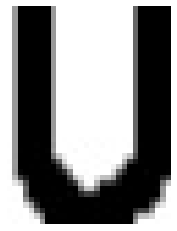

KNN: ['10'] SVM: ['10']


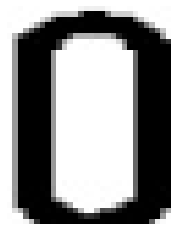

KNN: ['heart'] SVM: ['heart']


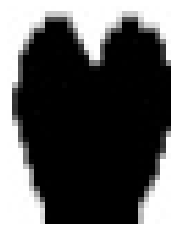

KNN: ['5'] SVM: ['5']


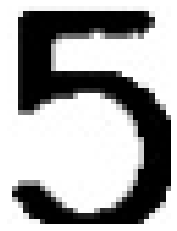

KNN: ['heart'] SVM: ['heart']


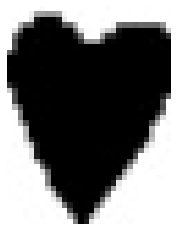

KNN: ['J'] SVM: ['J']


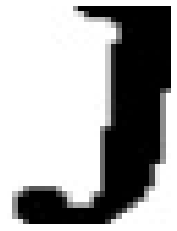

KNN: ['club'] SVM: ['club']


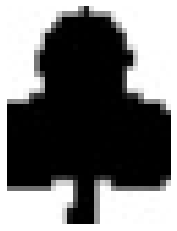

KNN: ['10'] SVM: ['10']


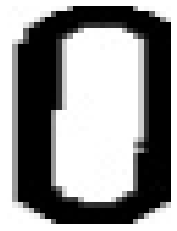

KNN: ['club'] SVM: ['club']


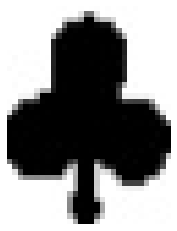

KNN: ['9'] SVM: ['9']


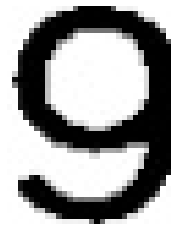

KNN: ['diamond'] SVM: ['diamond']


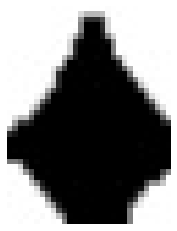

KNN: ['A'] SVM: ['A']


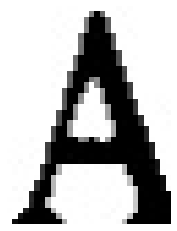

KNN: ['Q'] SVM: ['Q']


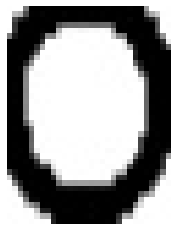

KNN: ['club'] SVM: ['club']


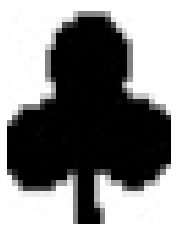

KNN: ['10'] SVM: ['10']


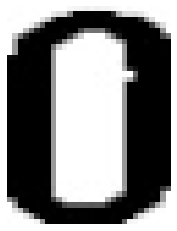

KNN: ['heart'] SVM: ['heart']


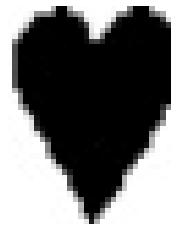

KNN: ['J'] SVM: ['J']


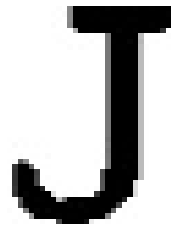

KNN: ['club'] SVM: ['club']


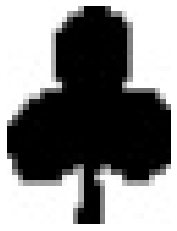

KNN: ['10'] SVM: ['10']


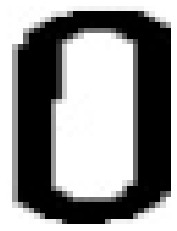

KNN: ['heart'] SVM: ['heart']


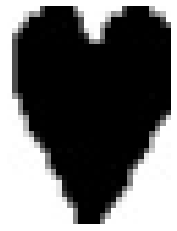

KNN: ['J'] SVM: ['J']


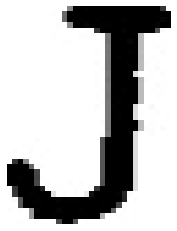

KNN: ['heart'] SVM: ['heart']


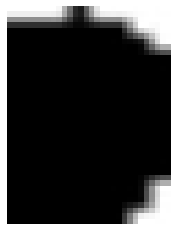

KNN: ['diamond'] SVM: ['diamond']


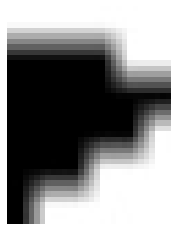

KNN: ['8'] SVM: ['8']


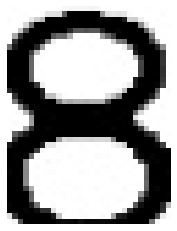

KNN: ['heart'] SVM: ['heart']


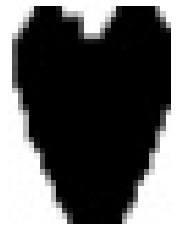

KNN: ['J'] SVM: ['J']


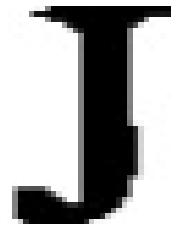

KNN: ['diamond'] SVM: ['diamond']


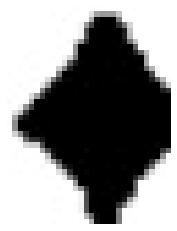

KNN: ['A'] SVM: ['A']


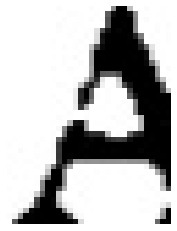

KNN: ['club'] SVM: ['club']


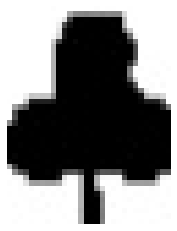

KNN: ['10'] SVM: ['10']


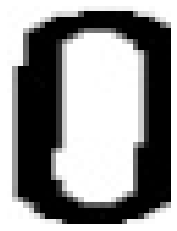

KNN: ['diamond'] SVM: ['diamond']


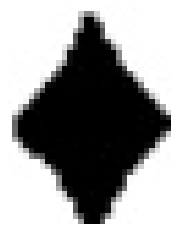

KNN: ['5'] SVM: ['5']


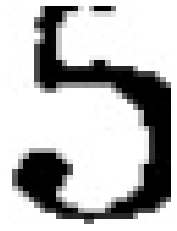

KNN: ['heart'] SVM: ['heart']


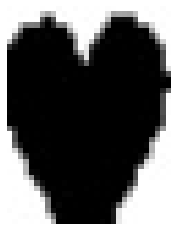

KNN: ['J'] SVM: ['J']


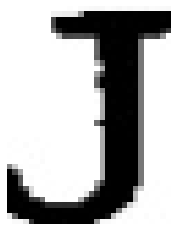

KNN: ['J'] SVM: ['J']


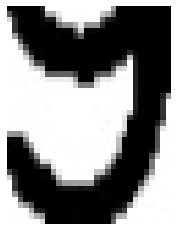

KNN: ['heart'] SVM: ['heart']


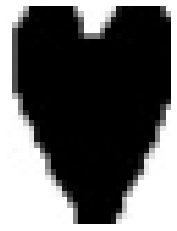

KNN: ['K'] SVM: ['K']


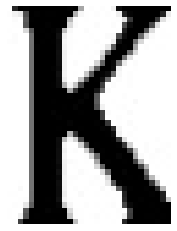

KNN: ['heart'] SVM: ['heart']


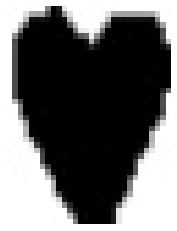

KNN: ['J'] SVM: ['J']


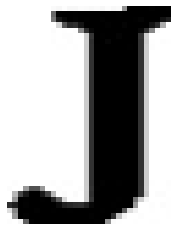

KNN: ['spade'] SVM: ['spade']


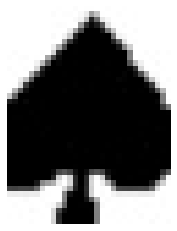

KNN: ['Q'] SVM: ['Q']


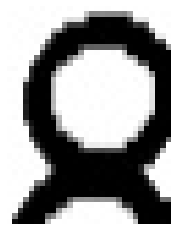

KNN: ['J'] SVM: ['J']


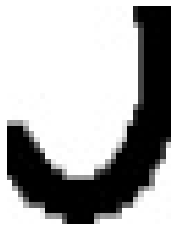

KNN: ['10'] SVM: ['5']


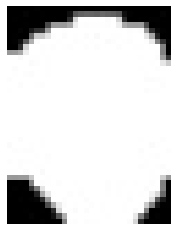

KNN: ['heart'] SVM: ['heart']


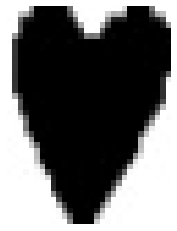

KNN: ['J'] SVM: ['J']


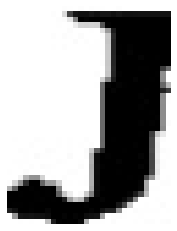

KNN: ['9'] SVM: ['9']


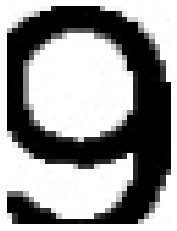

KNN: ['club'] SVM: ['club']


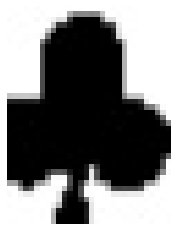

KNN: ['10'] SVM: ['10']


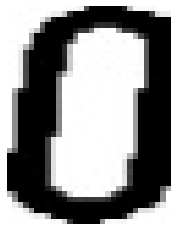

KNN: ['diamond'] SVM: ['club']


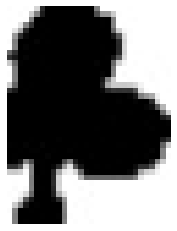

KNN: ['6'] SVM: ['6']


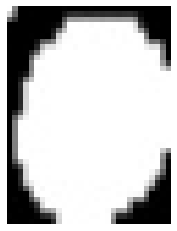

KNN: ['heart'] SVM: ['heart']


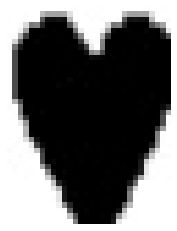

KNN: ['J'] SVM: ['A']


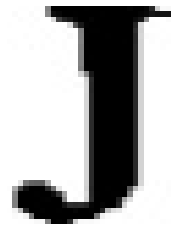

KNN: ['heart'] SVM: ['heart']


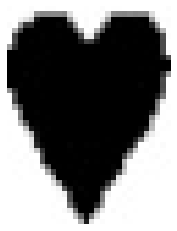

KNN: ['J'] SVM: ['J']


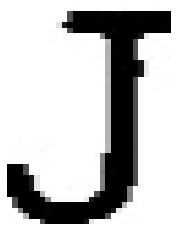

KNN: ['club'] SVM: ['club']


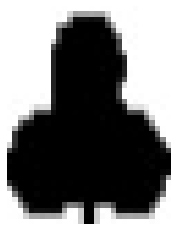

KNN: ['9'] SVM: ['9']


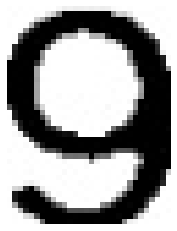

KNN: ['heart'] SVM: ['heart']


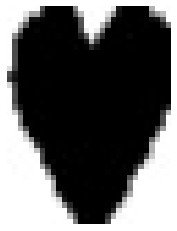

KNN: ['heart'] SVM: ['heart']


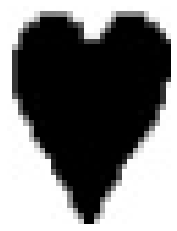

KNN: ['Q'] SVM: ['8']


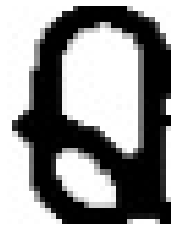

KNN: ['club'] SVM: ['club']


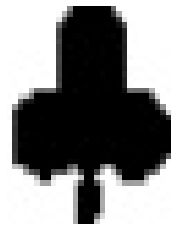

KNN: ['10'] SVM: ['10']


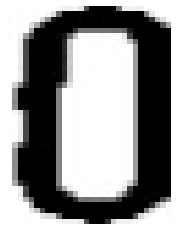

KNN: ['spade'] SVM: ['spade']


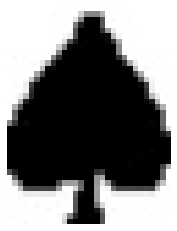

KNN: ['K'] SVM: ['K']


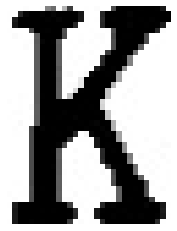

KNN: ['5'] SVM: ['5']


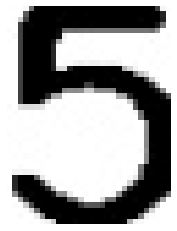

KNN: ['spade'] SVM: ['spade']


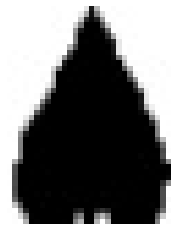

KNN: ['2'] SVM: ['2']


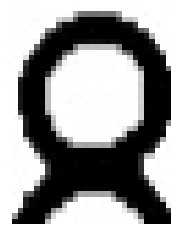

In [102]:
import os

dire="dataSet/testData/"
for filename in os.listdir(dire):
    image = cv2.imread(dire+filename, cv2.COLOR_BGR2GRAY)/255.0
    image.resize(40, 30)
    # print("KNN:", model_KNN.predict([image.flatten()]), "SVM:", model_SVC.predict([image.flatten()]))
    # showImage(image)
    imageInverted = 1-image 
    # print("SVM:", model_SVC.predict([imageInverted.flatten()]))
    print("KNN:", model_KNN.predict([image.flatten()]), "SVM:", model_SVC.predict([image.flatten()]))
    showImage(imageInverted)